-------------
# Differential Side-Channel Attack on XMEGA AES traces
#### Unsupervised
Here we are using:

- the open source library scared https://gitlab.com/eshard/scared
- the open source side-channel library Lascar is also an equivalent alternative https://github.com/Ledger-Donjon/lascar
    
-------------



In [1]:
import estraces
import scared

In [2]:
import numpy as np

In [3]:
from ipywidgets import interact, widgets
vhex = np.vectorize(hex)

In [4]:
ths = estraces.read_ths_from_ets_file('../SideCA-Traces/AES_xmega_traces_set_NewAE.ets')
print(ths)

Trace Header Set:
Name.............: ETS Format THS
Reader...........: ETS format reader of file ../SideCA-Traces/AES_xmega_traces_set_NewAE.ets with 50 traces.
key..............: uint8
plaintext........: uint8



In [6]:
import matplotlib.pyplot as plt

In [7]:
plt.rcParams['figure.figsize']=(16,4)

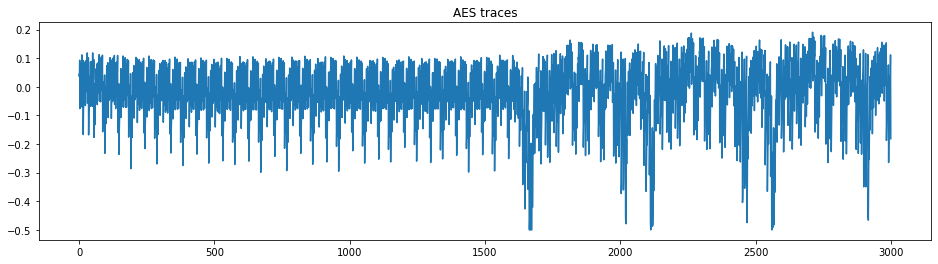

In [8]:
plt.plot(ths.samples[0:1].T)
plt.title('AES traces')
plt.show()

In [9]:
len(ths)

50

In [10]:
ths.metadata_tags

['key', 'plaintext']

In [11]:
# Create a container for your ths
container = scared.Container(ths)

### Where to attack?

#### see slides

----
## Attack the first round with DPA

In [12]:
attack_dpa = scared.DPAAttack(
        selection_function=scared.aes.selection_functions.encrypt.FirstSubBytes(),
        model=scared.Monobit(0),
        discriminant=scared.maxabs,
        convergence_step=len(ths)//5    
    )

In [13]:
attack_dpa.run(container)

/Users/bfeix/opt/miniconda3/lib/python3.7/site-packages/scared/distinguishers/dpa.py:49: RuntimeWarning: invalid value encountered in true_divide
  normalized_ones = (self.accumulator_ones.swapaxes(0, 1) / self.processed_ones).swapaxes(0, 1)
/Users/bfeix/opt/miniconda3/lib/python3.7/site-packages/scared/distinguishers/dpa.py:52: RuntimeWarning: invalid value encountered in true_divide
  normalized_zeros = (accumulator_zeros.swapaxes(0, 1) / processed_zeros).swapaxes(0, 1)
/Users/bfeix/opt/miniconda3/lib/python3.7/site-packages/scared/discriminants.py:64: RuntimeWarning: All-NaN slice encountered
  return _np.nanmax(_np.absolute(data), axis=axis)


In [14]:
found_key = attack_dpa.scores.argmax(0).squeeze()

In [15]:
vhex = np.vectorize(hex)
print("the key found is: ", vhex(found_key))

the key found is:  ['0x92' '0xd7' '0x33' '0x21' '0x55' '0x3' '0x24' '0x74' '0x7' '0xfb'
 '0x44' '0x36' '0xb' '0xb7' '0x29' '0x54']


#### Plot Results

In [16]:
import aLibrary.attack_results_scared_dist as scared_attack_result

In [17]:
figure_name_path = './attack_dpa_xmega_'

In [18]:
attack_result = scared_attack_result.attack_results_scared_dist(attack_dpa, figure_name_path, file_name_path=None)

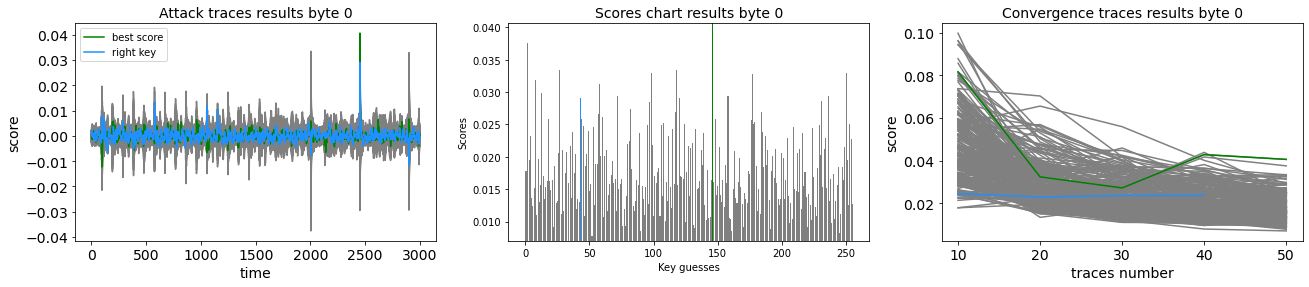

Best guess for byte 0 = 0x92
Correct guess for byte : 0=0x2b


In [19]:
attack_result.plot(0, ths.key[0], do_not_save_figure_bool=True)

### Print attack results

In [20]:
attack_result.print_scores(ths.key[0])

__Best guesses for all key bytes__


Bytes|0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15
------|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--
guess |0x92|0xd7|0x33|0x21|0x55|0x3|0x24|0x74|0x7|0xfb|0x44|0x36|0xb|0xb7|0x29|0x54
score |0.04061|0.04483|0.03882|0.04100|0.04291|0.04449|0.04903|0.03966|0.04094|0.04214|0.04501|0.05497|0.06145|0.04335|0.04062|0.04391
right key |0x2b|0x7e|0x15|0x16|0x28|0xae|0xd2|0xa6|0xab|0xf7|0x15|0x88|0x9|0xcf|0x4f|0x3c
rank |14|12|151|211|101|196|86|194|204|43|251|7|148|137|156|110

------ 
## Plot Remaining Key Entropy and Traces Number 

#### Naive entropy estimation:
- worst cases
- best cases



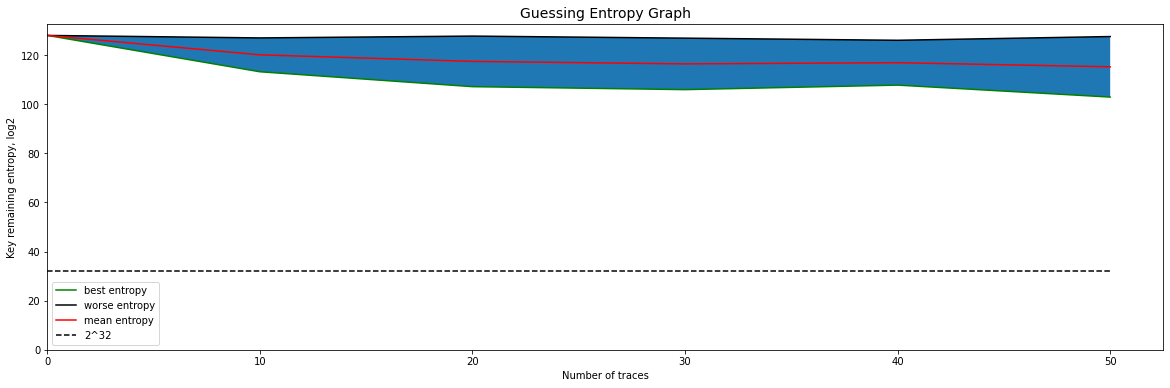

-----------------------------------------------------------
Number of traces for full key recovery            =  None
-----------------------------------------------------------
Number of traces for 32-bit remaining max-entropy  =  None
Number of traces for 32-bit remaining min-entropy  =  None
Number of traces for 32-bit remaining mean-entropy =  None
-----------------------------------------------------------


In [21]:
key_rank_lower, key_rank_est, key_rank_max = attack_result.remaining_entropy_naive(ths.key[0], do_not_save_figure_bool=True)

------ 
## Plot Remaining Key Entropy and Traces Number 

Improved estimation method in

- [GlowaczGPSS15] Cezary Glowacz, Vincent Grosso, Romain Poussier, Joachim Schüth, François-Xavier Standaert:
Simpler and More Efficient Rank Estimation for Side-Channel Security Assessment. FSE 2015: 117-129




/Users/bfeix/_Cyrano/GitSCARepo/SideCA/aLibrary/attack_results_scared_dist.py:483: RuntimeWarning: divide by zero encountered in log
  q=_np.log(p)


-----------------------------------------------------------
Number of traces for full key recovery            =  None
-----------------------------------------------------------
Number of traces for 32-bit remaining entropy: 
-- Higher bound entropy  =  None
-- Lower bound entropy   =  None
-- Estimated entropy     =  None
-----------------------------------------------------------


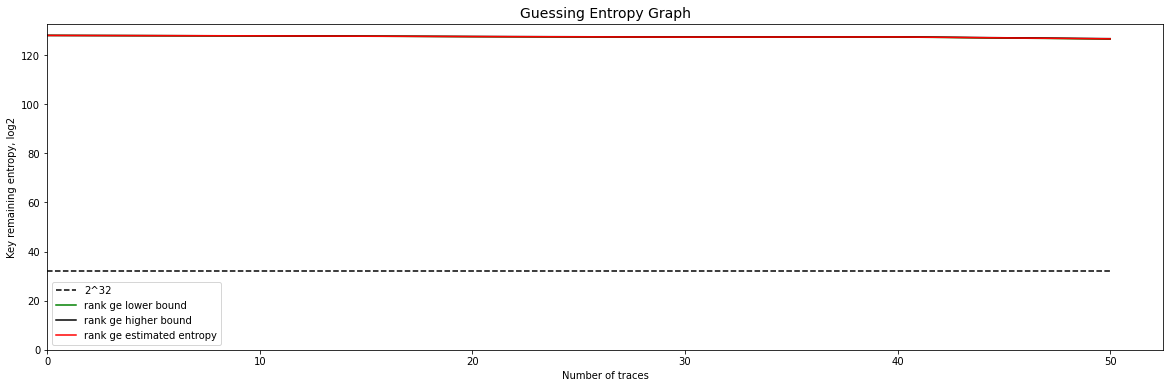

In [22]:
key_rank_lower, key_rank_est, key_rank_max = attack_result.remaining_entropy(ths.key[0], do_not_save_figure_bool=True)

----
## Attack the first round with CPA

In [23]:
attack_cpa = scared.CPAAttack(
        selection_function=scared.aes.selection_functions.encrypt.FirstSubBytes(),
        model=scared.HammingWeight(),
        discriminant=scared.maxabs,
        convergence_step=len(ths)//5    
    )

In [24]:
attack_cpa.run(container)

/Users/bfeix/opt/miniconda3/lib/python3.7/site-packages/scared/distinguishers/cpa.py:53: RuntimeWarning: invalid value encountered in true_divide
  tmp_result = (xy - (self.ex * (y / self.processed_traces))) / (common_1 * com_2)
/Users/bfeix/opt/miniconda3/lib/python3.7/site-packages/scared/distinguishers/cpa.py:53: RuntimeWarning: divide by zero encountered in true_divide
  tmp_result = (xy - (self.ex * (y / self.processed_traces))) / (common_1 * com_2)


In [25]:
found_key = attack_cpa.scores.argmax(0).squeeze()

#### Plot and Save Results

In [26]:
figure_name_path = './attack_cpa_xmega_'

In [27]:
attack_result = scared_attack_result.attack_results_scared_dist(attack_cpa, figure_name_path=figure_name_path, file_name_path=None)

Best guess for byte 0 = 0x2b
Correct guess for byte : 0=0x2b


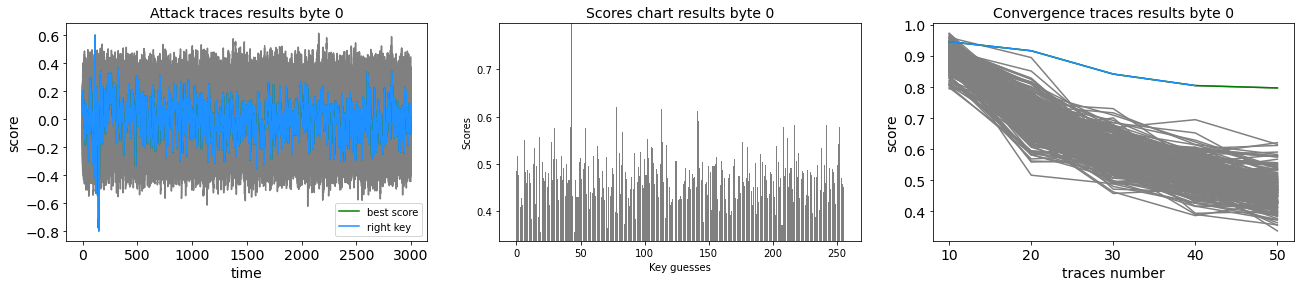

In [28]:
attack_result.plot(0, ths.key[0])

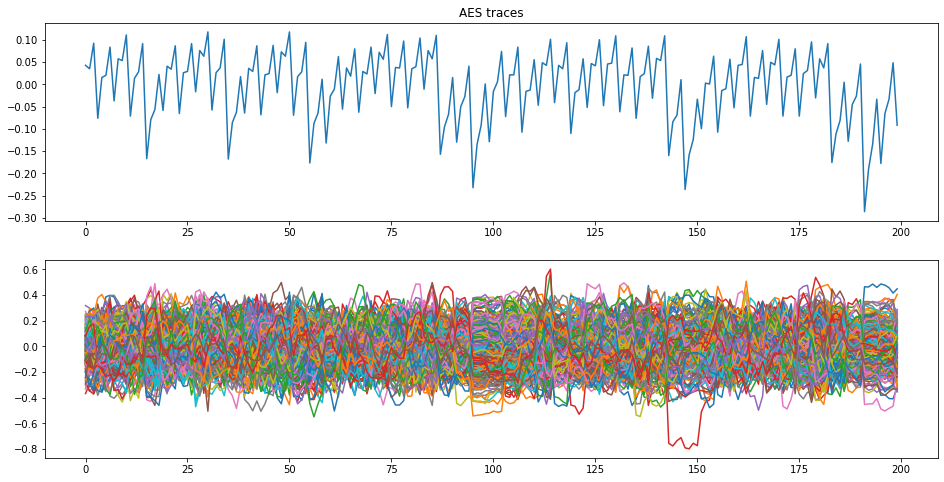

In [29]:
plt.rcParams['figure.figsize']=(16,8)

plt.subplot(2,1,1)
plt.plot(ths.samples[0:1].T[0:200])
plt.title('AES traces')

plt.subplot(2,1,2)
plt.plot(attack_cpa.results[:,0,0:200].T)
plt.show()

#### Plot and Save ALL Bytes Results

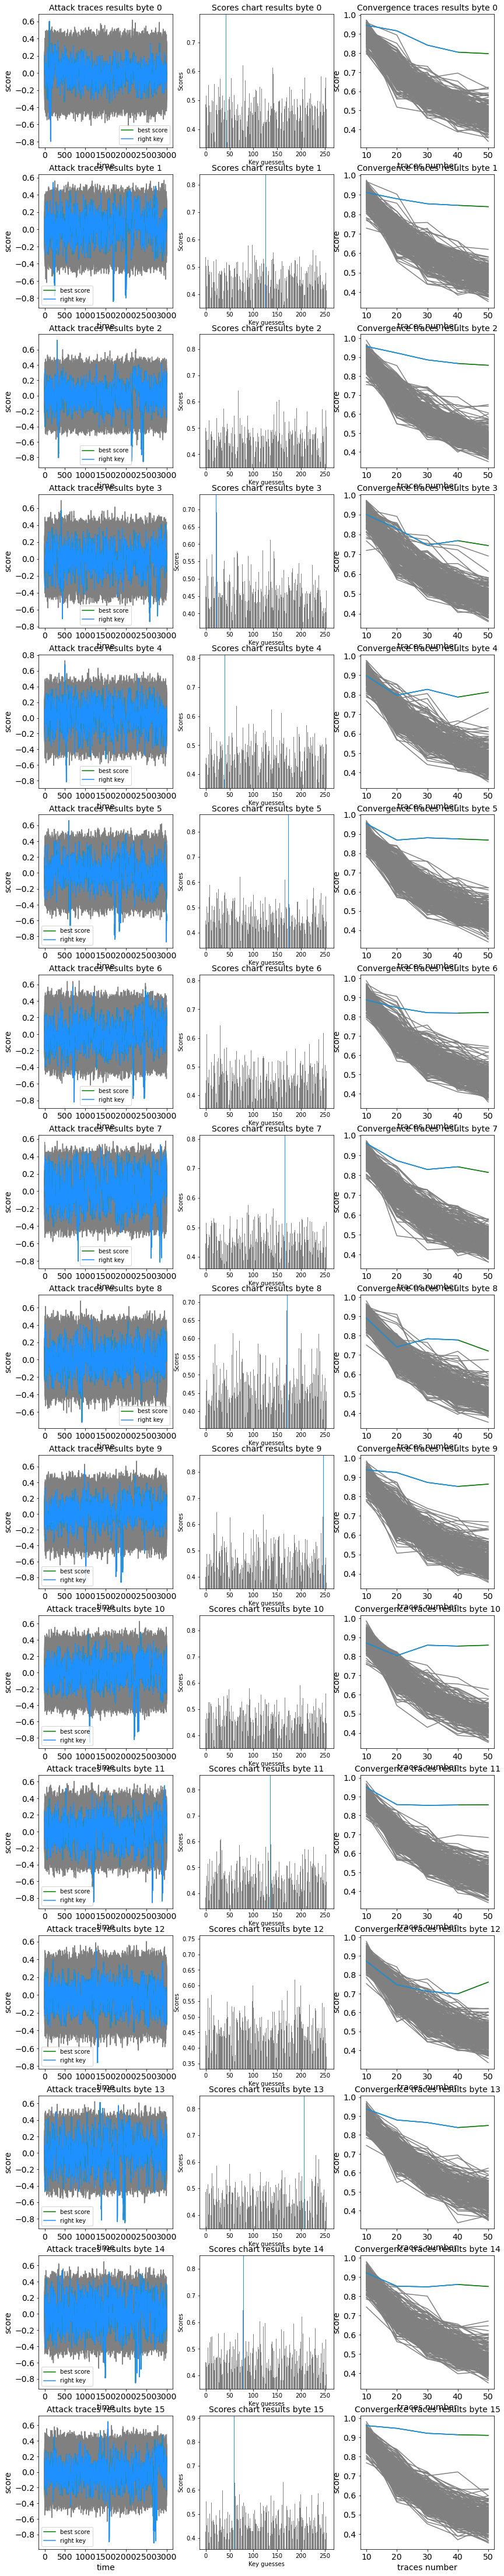

In [30]:
attack_result.plot(None, ths.key[0])

### Print attack results

In [31]:
attack_result.print_scores(ths.key[0])

__Best guesses for all key bytes__


Bytes|0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15
------|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--
guess |0x2b|0x7e|0x15|0x16|0x28|0xae|0xd2|0xa6|0xab|0xf7|0x15|0x88|0x9|0xcf|0x4f|0x3c
score |0.79753|0.83871|0.85671|0.74356|0.81287|0.86857|0.82060|0.81377|0.72061|0.86455|0.85859|0.85660|0.76111|0.85017|0.85011|0.90990
right key |0x2b|0x7e|0x15|0x16|0x28|0xae|0xd2|0xa6|0xab|0xf7|0x15|0x88|0x9|0xcf|0x4f|0x3c
rank |1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1

------ 
## Plot Remaining Key Entropy and Traces Number 

#### Naive entropy estimation:
- worst cases
- best cases



-----------------------------------------------------------
Number of traces for full key recovery            =  40
-----------------------------------------------------------
Number of traces for 32-bit remaining max-entropy  =  40
Number of traces for 32-bit remaining min-entropy  =  20
Number of traces for 32-bit remaining mean-entropy =  30
-----------------------------------------------------------


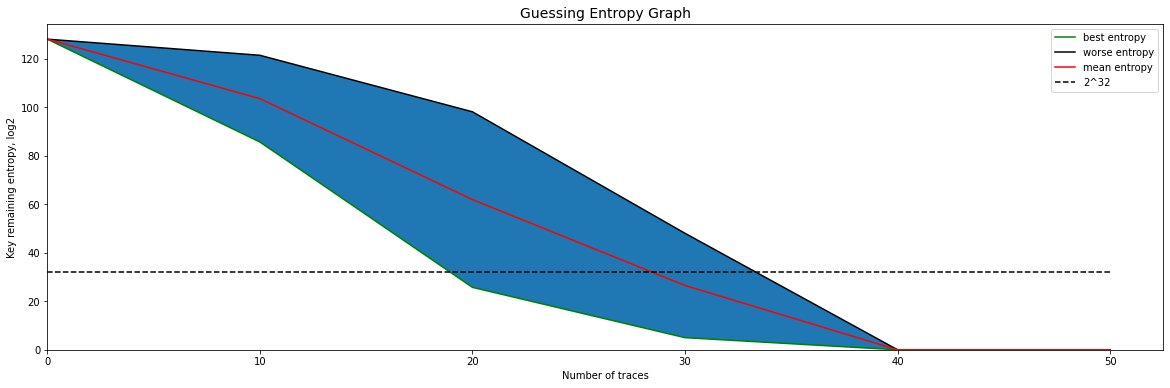

In [32]:
key_rank_lower, key_rank_est, key_rank_max = attack_result.remaining_entropy_naive(ths.key[0])

------ 
## Plot Remaining Key Entropy and Traces Number 

Improved estimation method in

- [GlowaczGPSS15] Cezary Glowacz, Vincent Grosso, Romain Poussier, Joachim Schüth, François-Xavier Standaert:
Simpler and More Efficient Rank Estimation for Side-Channel Security Assessment. FSE 2015: 117-129




-----------------------------------------------------------
Number of traces for full key recovery            =  40
-----------------------------------------------------------
Number of traces for 32-bit remaining entropy: 
-- Higher bound entropy  =  30
-- Lower bound entropy   =  30
-- Estimated entropy     =  30
-----------------------------------------------------------


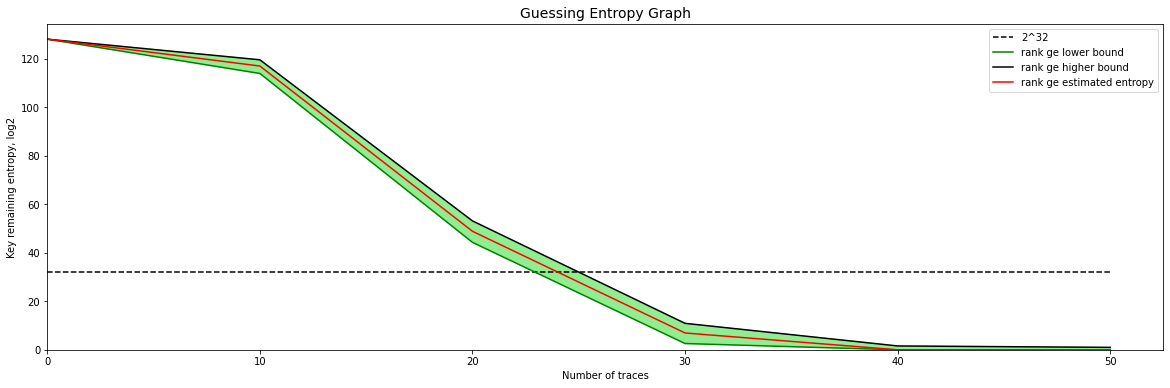

In [33]:
key_rank_lower, key_rank_est, key_rank_max = attack_result.remaining_entropy(ths.key[0])

### Print attack best results

In [34]:
attack_result.print_best_scores(5)

__Best 5 guesses for all key bytes__


Bytes|0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15
------|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--
guess/score |(0x2b, 0.798)|(0x7e, 0.839)|(0x15, 0.857)|(0x16, 0.744)|(0x28, 0.813)|(0xae, 0.869)|(0xd2, 0.821)|(0xa6, 0.814)|(0xab, 0.721)|(0xf7, 0.865)|(0x15, 0.859)|(0x88, 0.857)|(0x9, 0.761)|(0xcf, 0.850)|(0x4f, 0.850)|(0x3c, 0.910)
guess/score |(0x4e, 0.621)|(0x4b, 0.620)|(0x14, 0.650)|(0x17, 0.691)|(0x29, 0.730)|(0x48, 0.621)|(0x1e, 0.644)|(0xce, 0.579)|(0xaa, 0.677)|(0xd3, 0.669)|(0x1a, 0.628)|(0xd9, 0.684)|(0xa8, 0.622)|(0xe7, 0.624)|(0x1a, 0.671)|(0xa3, 0.633)
guess/score |(0x71, 0.616)|(0x62, 0.582)|(0x44, 0.642)|(0x88, 0.613)|(0x41, 0.635)|(0x1f, 0.620)|(0xd3, 0.635)|(0xd3, 0.578)|(0xc9, 0.615)|(0x17, 0.646)|(0xc6, 0.591)|(0x61, 0.609)|(0xbb, 0.619)|(0xed, 0.610)|(0x4e, 0.646)|(0x3d, 0.631)
guess/score |(0x8d, 0.613)|(0x59, 0.579)|(0x9a, 0.606)|(0x78, 0.582)|(0x8a, 0.624)|(0xa6, 0.609)|(0xf7, 0.618)|(0x59, 0.576)|(0x39, 0.614)|(0x79, 0.637)|(0x5c, 0.580)|(0x20, 0.608)|(0xe, 0.604)|(0x34, 0.608)|(0xca, 0.621)|(0x23, 0.598)
guess/score |(0x8e, 0.591)|(0x82, 0.570)|(0x95, 0.600)|(0x42, 0.579)|(0x9f, 0.612)|(0x8, 0.589)|(0x2, 0.614)|(0x3f, 0.576)|(0xed, 0.614)|(0xf6, 0.629)|(0x31, 0.575)|(0x1e, 0.606)|(0x63, 0.601)|(0x32, 0.593)|(0x72, 0.604)|(0x4a, 0.598)


-----
## Attack the last round in delta with ANOVA

In [35]:
attack_anova = scared.ANOVAAttack(
        selection_function=scared.aes.selection_functions.encrypt.FirstSubBytes(),
        model=scared.HammingWeight(),
        discriminant=scared.maxabs,
        convergence_step=len(ths)//5    
    )

In [36]:
attack_anova.run(container)

/Users/bfeix/opt/miniconda3/lib/python3.7/site-packages/scared/distinguishers/partitioned.py:150: RuntimeWarning: invalid value encountered in true_divide
  return numerator / denominator
/Users/bfeix/opt/miniconda3/lib/python3.7/site-packages/scared/distinguishers/partitioned.py:150: RuntimeWarning: divide by zero encountered in true_divide
  return numerator / denominator


#### Plot Results

In [37]:
attack_result = scared_attack_result.attack_results_scared_dist(attack_anova)

In [38]:
attack_result.print_scores(ths[0].key)

__Best guesses for all key bytes__


Bytes|0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15
------|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--
guess |0x2b|0x7e|0x15|0xe1|0x28|0xae|0xd2|0xa6|0x9f|0xf7|0x15|0x88|0x9|0xcf|0x4f|0x3c
score |15.24172|16.97268|21.68869|11.23374|19.08291|23.20034|23.35393|20.80446|11.11534|27.87494|22.82116|30.93708|17.83821|20.37219|20.55307|43.85727
right key |0x2b|0x7e|0x15|0x16|0x28|0xae|0xd2|0xa6|0xab|0xf7|0x15|0x88|0x9|0xcf|0x4f|0x3c
rank |1|1|1|2|1|1|1|1|3|1|1|1|1|1|1|1

-----------------------------------------------------------
Number of traces for full key recovery            =  None
-----------------------------------------------------------
Number of traces for 32-bit remaining entropy: 
-- Higher bound entropy  =  40
-- Lower bound entropy   =  40
-- Estimated entropy     =  40
-----------------------------------------------------------


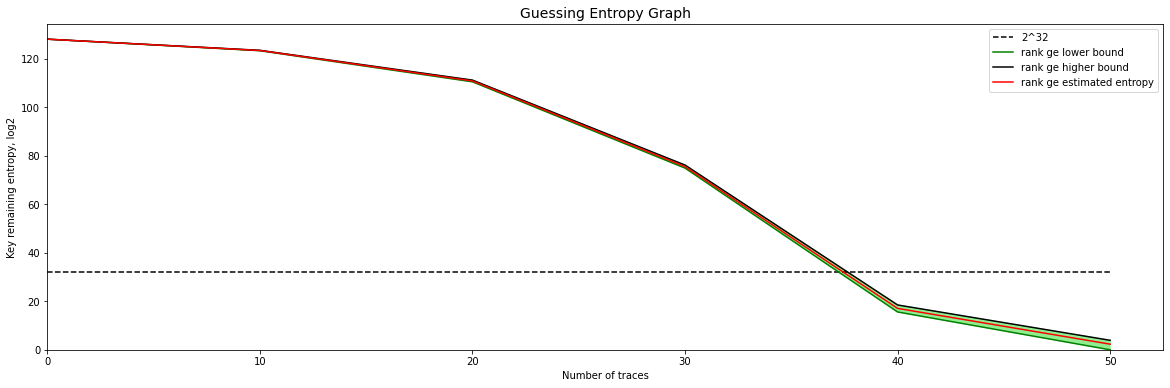

In [39]:
key_rank_lower, key_rank_est, key_rank_max = attack_result.remaining_entropy(ths[0].key)

Best guess for byte 0 = 0x2b
Correct guess for byte : 0=0x2b


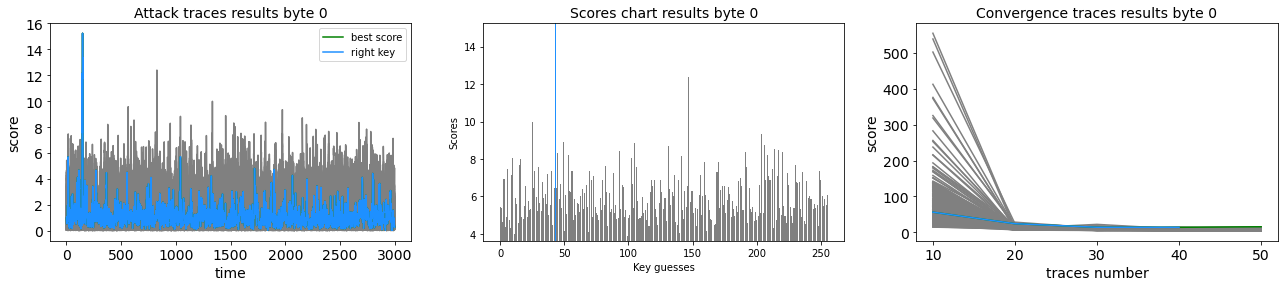

In [40]:
attack_result.plot(0, ths[0].key)